# Explore dataset

## Set-up

### Imports

In [1]:
# imports - general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch
from mne.time_frequency import tfr_array_multitaper

# imports - custom
import sys
sys.path.append("../code")
from info import FS, N_CHANNELS#, N_SPECIES

# autoreload
%load_ext autoreload
%autoreload 2

## Main

### Load data

In [2]:
# load example file
i_file = 0

# import
path = '../../../datasets/adamatzky_2021/txt'
files = os.listdir(path)
print(f"Importing: {files[i_file]}")
data = pd.read_csv(os.path.join(path, files[i_file]), sep='\t')

# check signal duration
n_samples = len(data)
print(f"\nNumber of samples: {n_samples}")
print(f"Signal duration: \n\t{n_samples/FS} seconds \n\t~{n_samples/(FS*60):.0f} minutes \n\t~{n_samples/(FS*60*60):.0f} hours \n\t~{n_samples/(FS*60*60*24):.0f} days")

# show
data

Importing: cordyceps_militari.txt

Number of samples: 1900145
Signal duration: 
	1900145.0 seconds 
	~31669 minutes 
	~528 hours 
	~22 days


,Differential 1 - 2 Ave. (mV),Differential 3 - 4 Ave. (mV),Differential 5 - 6 Ave. (mV),Differential 7 - 8 Ave. (mV),Differential 9 - 10 Ave. (mV),Differential 11 - 12 Ave. (mV),Differential 13 - 14 Ave. (mV),Unnamed: 7,Unnamed: 8,Unnamed: 9
0,-0.448,-1.762,1.349,3.886,0.241,-0.881,0.502,0.000000,0.0,0.0
1,-0.450,-1.727,1.455,3.838,0.228,-0.881,0.461,0.000000,0.0,0.0
2,-0.404,-1.620,1.709,3.779,0.233,-0.892,0.340,0.062631,0.0,0.0
3,-0.305,-1.528,1.923,3.797,0.272,-0.901,0.245,0.107730,0.0,0.0
4,-0.194,-1.502,1.906,3.874,0.318,-0.911,0.237,0.126773,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1900140,0.792,-0.355,0.913,-0.335,1.581,0.249,0.756,NaN,NaN,NaN
1900141,0.791,-0.276,1.028,-0.326,1.591,0.234,0.679,NaN,NaN,NaN
1900142,0.791,-0.208,0.834,-0.309,1.585,0.229,0.673,NaN,NaN,NaN
1900143,0.792,-0.151,0.848,-0.271,1.590,0.216,0.708,NaN,NaN,NaN


Something isn't matching up here. The documentation states that the sampling frequency is 1 Hz and the recording length is 1.5 days for S. commune and c. 5 days for the other species. Yet, here, the signal durations works out to be much longer (3 days for S. commune and 12+, 20+, and 35+ days for the others)

In [3]:
# check for NaN
print(f"Number of NaNs: \n{np.sum(np.isnan(data))}")

Number of NaNs: 
Differential 1 - 2 Ave. (mV)          90
Differential 3 - 4 Ave. (mV)          90
Differential 5 - 6 Ave. (mV)          90
Differential 7 - 8 Ave. (mV)          90
Differential 9 - 10 Ave. (mV)         90
Differential 11 - 12 Ave. (mV)        90
Differential 13 - 14 Ave. (mV)        90
Unnamed: 7                        852575
Unnamed: 8                        851569
Unnamed: 9                        851569
dtype: int64


### Plot time-series

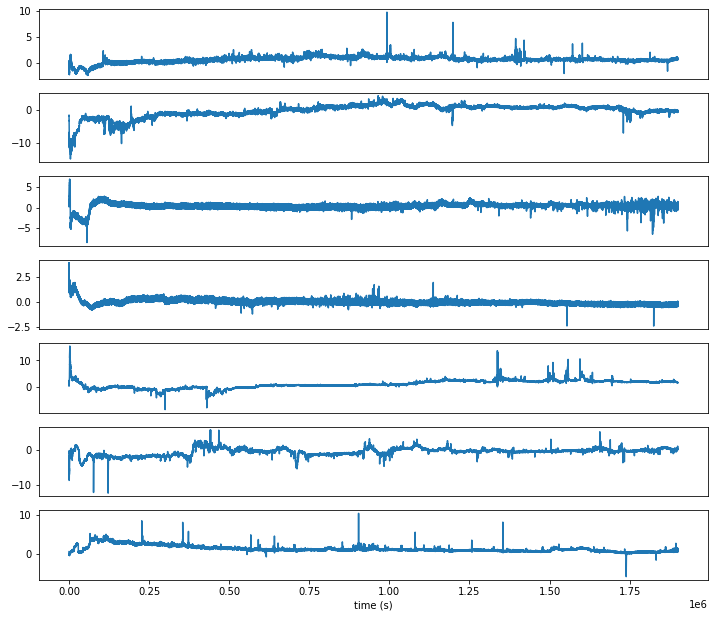

In [4]:
# plot each channel
time = np.arange(n_samples) / FS

fig, ax = plt.subplots(N_CHANNELS, 1, figsize=(12, N_CHANNELS*1.5))
for i in range(N_CHANNELS):
    ax[i].plot(time, data.iloc[:, i])
    if i < N_CHANNELS-1:
        ax[i].set(xticks=[], xlabel='')

ax[N_CHANNELS-1].set(xlabel='time (s)');

All channels exhibit large deflections at the beginning of the recording, which may be due to the experimental manipulation.

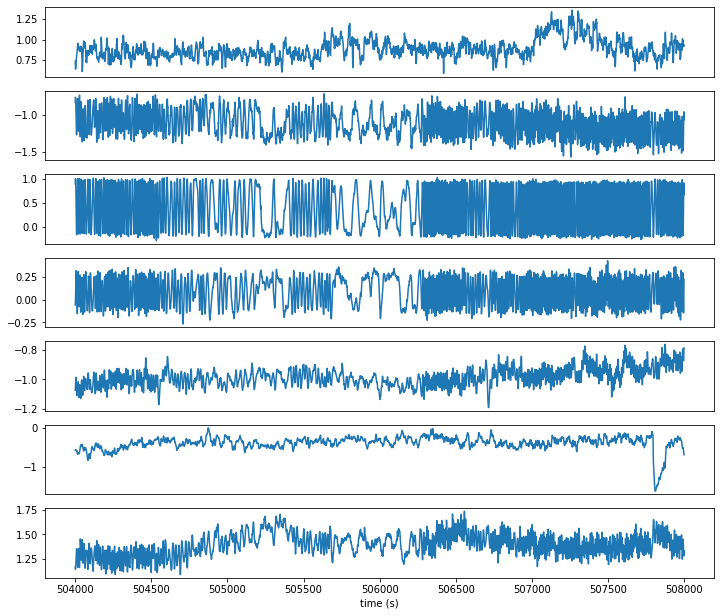

In [5]:
# plot a snippet of each channel
fig, ax = plt.subplots(N_CHANNELS, 1, figsize=(12, N_CHANNELS*1.5))
for i in range(N_CHANNELS):
    ax[i].plot(time[504000:508000], data.iloc[504000:508000, i])
    if i < N_CHANNELS-1:
        ax[i].set(xticks=[], xlabel='')

ax[N_CHANNELS-1].set(xlabel='time (s)');

For file 0, channels 1, 2, and 3 appear to transition between bouts of slow wave activity and white-noise-like activity.

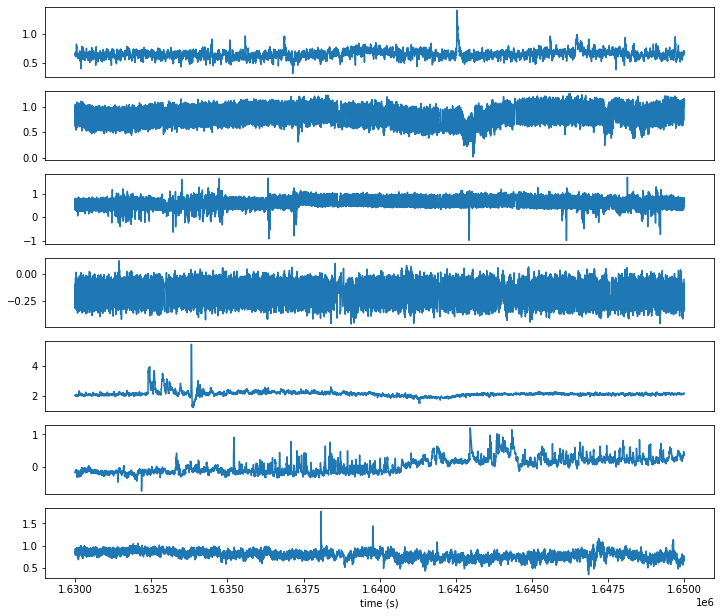

In [6]:
# plot another snippet of each channel
fig, ax = plt.subplots(N_CHANNELS, 1, figsize=(12, N_CHANNELS*1.5))
for i in range(N_CHANNELS):
    ax[i].plot(time[1630000:1650000], data.iloc[1630000:1650000, i])
    if i < N_CHANNELS-1:
        ax[i].set(xticks=[], xlabel='')

ax[N_CHANNELS-1].set(xlabel='time (s)');

Recordings also exhibit large voltage defections (spikes) with both positive and negative amplitude. 

### Plot power spectra

In [7]:
# interpolate NaN values in signal (for computing spectra)
data = data.interpolate(method='linear', axis=0)

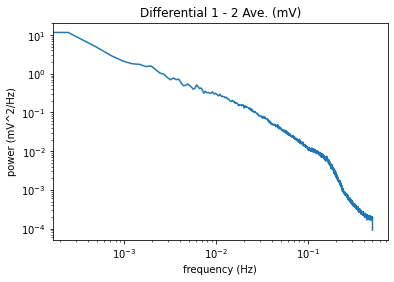

In [8]:
# plot power spectrum for example channel
i_col = 0

# compute power
signal = data.iloc[:, i_col].values
freq, power = welch(signal, fs=FS, nperseg=2**12)

# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog(freq, power)
ax.set(xlabel='frequency (Hz)', ylabel='power (mV^2/Hz)', title=data.columns[i_col])
plt.show()


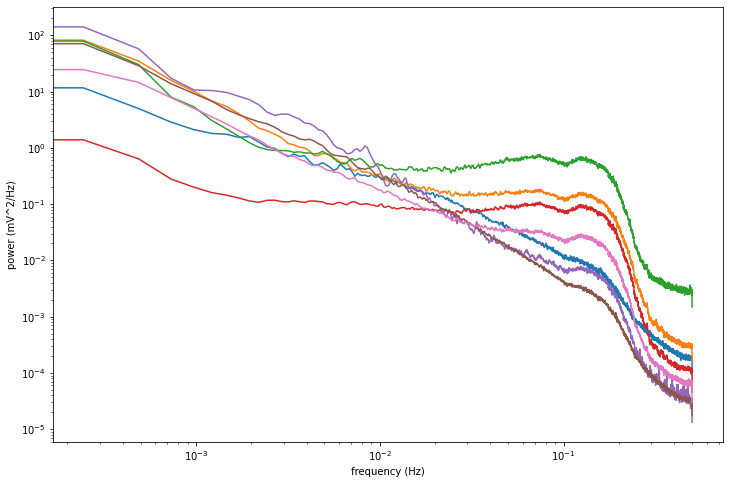

In [9]:
# compute spectra for each channel
spectra = np.zeros((N_CHANNELS, len(freq)))
for i in range(N_CHANNELS):
    freq, power = welch(data.iloc[:, i].values, fs=FS, nperseg=2**12)
    spectra[i, :] = power

# plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.loglog(freq, spectra.T)
ax.set(ylabel='power (mV^2/Hz)', xlabel='frequency (Hz)')
plt.show()

Spectra exhibit a 1/f-like form i.e. decreasing power with increasing frequency, that is roughly linear in log-log space. Additionally, a broad peak is apparent in the spectra, which may reflect the aforementioned slow-wave-like bouts or action-potential-like spikes. 

### plot spectrogram

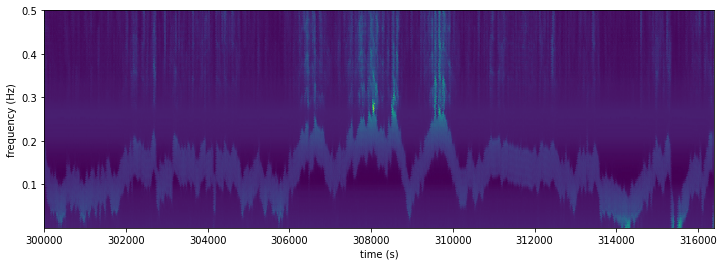

In [11]:
# compute spectrogram for example signal

# select signal snippet
n_samples = 2**14
start_idx = 300000
time_tfr = np.arange(start_idx, start_idx+n_samples) / FS
signal = data.iloc[start_idx:start_idx+n_samples, 2].values

# compute spectrogram
freq = np.linspace(1/n_samples, FS/2, 128)
time_window_length = 60
freq_bandwidth = 0.1
n_cycles = freq * time_window_length # set based on fixed window length
time_bandwidth =  time_window_length * freq_bandwidth # must be >= 2
spec = tfr_array_multitaper(signal[np.newaxis, np.newaxis, :], sfreq=FS, 
                            freqs=freq, n_cycles=n_cycles, 
                            time_bandwidth=time_bandwidth,
                            output='power')
spec = np.squeeze(spec)

# z-score
spec_z = np.zeros_like(spec)
for i_freq in range(len(freq)):
    spec_z[i_freq, :] = (spec[i_freq, :] - np.mean(spec[i_freq, :])) / np.std(spec[i_freq, :])

# plot spectrogram with signal overlay
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.pcolormesh(time_tfr, freq, spec_z, shading='gouraud')
ax.set(xlabel='time (s)', ylabel='frequency (Hz)')
plt.show()

Clear oscillatory peak for short time windows, with interesting peak frequency shifts over time.

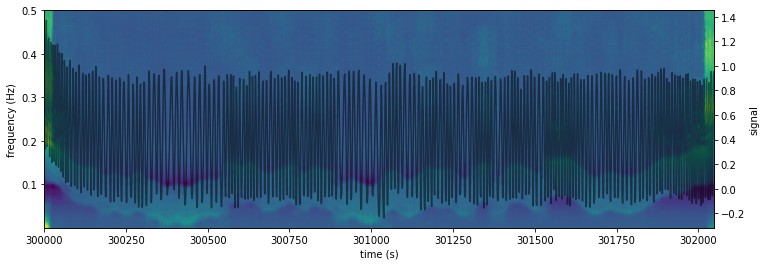

In [12]:
# compute spectrogram for example signal

# select signal snippet
n_samples = 2**11
start_idx = 300000
time_tfr = np.arange(start_idx, start_idx+n_samples) / FS
signal = data.iloc[start_idx:start_idx+n_samples, 2].values

# compute spectrogram
freq = np.linspace(1/n_samples, FS/2, 128)
time_window_length = 60
freq_bandwidth = 0.1
n_cycles = freq * time_window_length # set based on fixed window length
time_bandwidth =  time_window_length * freq_bandwidth # must be >= 2
spec = tfr_array_multitaper(signal[np.newaxis, np.newaxis, :], sfreq=FS, 
                            freqs=freq, n_cycles=n_cycles, 
                            time_bandwidth=time_bandwidth,
                            output='power')
spec = np.squeeze(spec)

# z-score
spec_z = np.zeros_like(spec)
for i_freq in range(len(freq)):
    spec_z[i_freq, :] = (spec[i_freq, :] - np.mean(spec[i_freq, :])) / np.std(spec[i_freq, :])

# plot spectrogram with signal overlay
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.pcolormesh(time_tfr, freq, spec_z, shading='gouraud')
ax.set(xlabel='time (s)', ylabel='frequency (Hz)')
ax2 = ax.twinx()
ax2.plot(time_tfr, signal, 'k', alpha=0.5)
ax2.set(ylabel='signal')
plt.show()

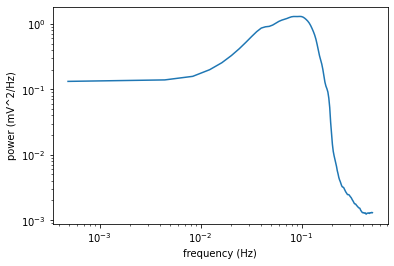

In [13]:
# plot mean spectra
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog(freq, np.mean(spec, axis=1))
ax.set(ylabel='power (mV^2/Hz)', xlabel='frequency (Hz)')
plt.show()

In [14]:
# compute spectrogram for each channel

# select signal snippet
n_samples = 2**14
start_idx = 300000
time_tfr = np.arange(start_idx, start_idx+n_samples) / FS
signal = data.iloc[start_idx:start_idx+n_samples, :7].values.T

# compute spectrogram
freq = np.linspace(1/n_samples, FS/2, 128)
time_window_length = 60
freq_bandwidth = 0.1
n_cycles = freq * time_window_length # set based on fixed window length
time_bandwidth =  time_window_length * freq_bandwidth # must be >= 2
spec = tfr_array_multitaper(signal[np.newaxis, :], sfreq=FS, 
                            freqs=freq, n_cycles=n_cycles, 
                            time_bandwidth=time_bandwidth,
                            output='power')
spec = np.squeeze(spec)
print(spec.shape)

(7, 128, 16384)


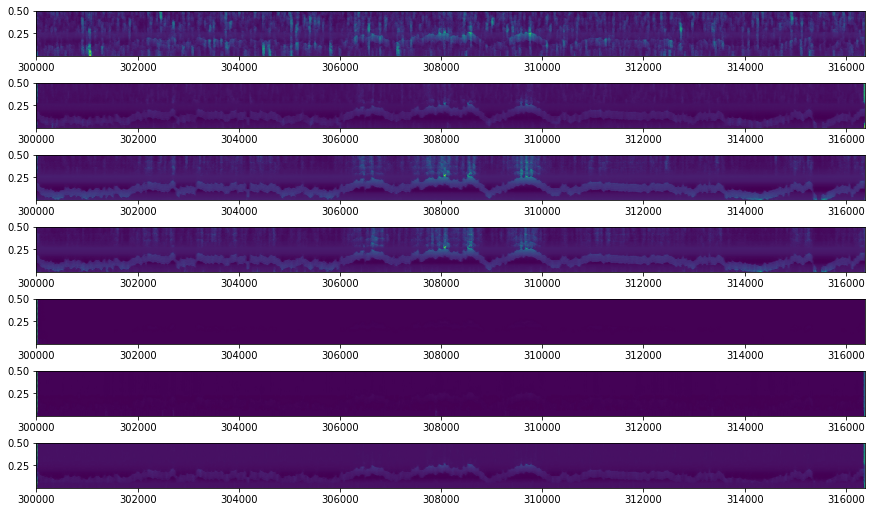

In [15]:
# plot each spectrogram stacked

# z-score spectrogram 
spec_z = np.zeros_like(spec)
for i_chan in range(N_CHANNELS):
    for i_freq in range(len(freq)):
        spec_z[i_chan, i_freq] = (spec[i_chan, i_freq] - np.mean(spec[i_chan, i_freq])) / np.std(spec[i_chan, i_freq])


# plot
fig, ax = plt.subplots(N_CHANNELS, 1, figsize=(12, N_CHANNELS), constrained_layout=True)
for i in range(N_CHANNELS):
    ax[i].pcolormesh(time_tfr, freq, spec_z[i], shading='gouraud')
plt.show()

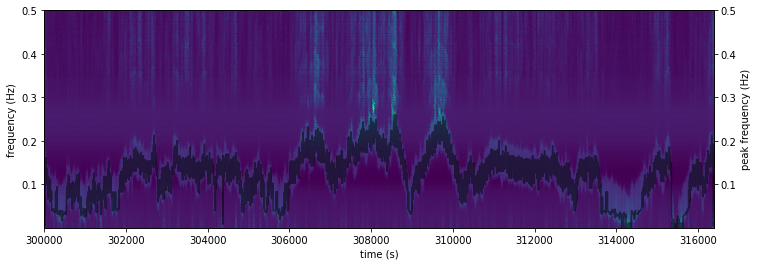

In [19]:
# find peak frequency for each time point
i_chan = 3
signal = spec[i_chan]
peak_freq = np.zeros(signal.shape[-1])
for i_bin in range(signal.shape[-1]):
    peak_freq[i_bin] = freq[np.argmax(signal[:, i_bin])]

# plot spectrogram with peak freq overlaid
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.pcolormesh(time_tfr, freq, spec_z[i_chan], shading='gouraud')
ax2 = ax.twinx()
ax2.sharey(ax)
ax2.plot(time_tfr, peak_freq, 'k', alpha=0.5)
ax.set(xlabel='time (s)', ylabel='frequency (Hz)')
ax2.set(ylabel='peak frequency (Hz)')
plt.show()

In [25]:
# compute peak frequency for each channel
peak_freq = np.zeros((N_CHANNELS, len(time_tfr)))
for i_chan in range(N_CHANNELS):
    signal = spec[i_chan]
    for i_bin in range(signal.shape[-1]):
        peak_freq[i_chan, i_bin] = freq[np.argmax(signal[:, i_bin])]

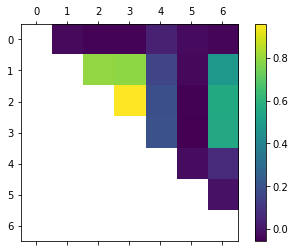

In [18]:
# correlate peak frequency across channels
corr = np.corrcoef(peak_freq)
corr_plt = corr.copy()
corr_plt[np.tril_indices(corr.shape[0])] = np.nan

# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
cax = ax.matshow(corr_plt, cmap='viridis')
fig.colorbar(cax)
plt.show()

The dymanic shifts in peak frequency of these waves is correlated across channels.

### Multi-band interactions

When the peak frequency of these waves increases, there appears to be a concurrent broadband increase in power. This likely reflects the nonsinusoidal shape of the wavees; as the frequncy increases, the waves likely get sharper.

In [27]:
# correlate peak frequncy and high-frequnecy power

# compute broadband high-frequnecy power
f_range = freq > 0.30
spec_high = np.zeros((N_CHANNELS, spec.shape[-1]))
for i_chan in range(N_CHANNELS):
    for i_bin in range(spec.shape[-1]):
        spec_high[i_chan, i_bin] = np.sum(spec[i_chan, f_range, i_bin])

# correlate
for i_chan in range(N_CHANNELS):
    corr = np.corrcoef(peak_freq[i_chan], spec_high[i_chan])
    print(f"Channel {i_chan}: {corr[0, 1]}")

Channel 0: 0.0814156379265045
Channel 1: 0.10276922520754038
Channel 2: 0.6852575644272147
Channel 3: 0.7179479216343548
Channel 4: -0.028623645477502808
Channel 5: 0.0034116840840897303
Channel 6: -0.05613668504840305


The peak frequency of the oscillation and total high-frequncy power are correlated, but only on channels that exhibit the clearest oscillation. For file 0, channels 2 and 3 show very high correlations; a relationship that is visually apparent in the spectrograms.

## Summary

Across all species, I observed oscillatory activity at a frequency of around 0.1 Hz (1 cycle per 10 seconds). This wave of activty exhibited dynamic shifts in peak frequncy across time that (in some instances) was highly correlated across channels. Furthermore, on channels with robust oscillations, the peak frequency was correlated with broadband high frequncy power. This 0.1 Hz wave is a yet undescribed mode of electrical activity in fungi and may be a mechanism for relaying information across space.